<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1">Подготовка</a></span><ul class="toc-item"><li><span><a href="#Вывод:" data-toc-modified-id="Вывод:-1.1">Вывод:</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2">Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3">Обучение</a></span><ul class="toc-item"><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-3.1">LinearRegression</a></span></li><li><span><a href="#RandomForestRegressor" data-toc-modified-id="RandomForestRegressor-3.2">RandomForestRegressor</a></span></li><li><span><a href="#CatBoostRegressor" data-toc-modified-id="CatBoostRegressor-3.3">CatBoostRegressor</a></span></li><li><span><a href="#Вывод:" data-toc-modified-id="Вывод:-3.4">Вывод:</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4">Тестирование</a></span></li><li><span><a href="#Общий-вывод:" data-toc-modified-id="Общий-вывод:-5">Общий вывод:</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Построим модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Нам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.

## Подготовка

In [1]:
# Загрузим необходимые нам для работы библиотеки

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from matplotlib import rcParams
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, TimeSeriesSplit, train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
# Устанавливаем размер графиков
rcParams['figure.figsize'] = 15, 5
# Загружаем датасет
df = pd.read_csv('/datasets/taxi.csv', parse_dates=[0], index_col=0).sort_index()
# Выводим первые 5 строк
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [3]:
# Смотрим основную информацию
df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [4]:
# Проверка на пропуски
df.isna().sum()

num_orders    0
dtype: int64

In [5]:
# Проверка на монотонность
df.index.is_monotonic_increasing

True

In [6]:
# Задаем интервал в час
df = df.resample('1h').sum()

### Вывод:
- Загрузил данные и изменил интервал на час.
- В данных нет пропусков.
- Типы данных корректны.


## Анализ

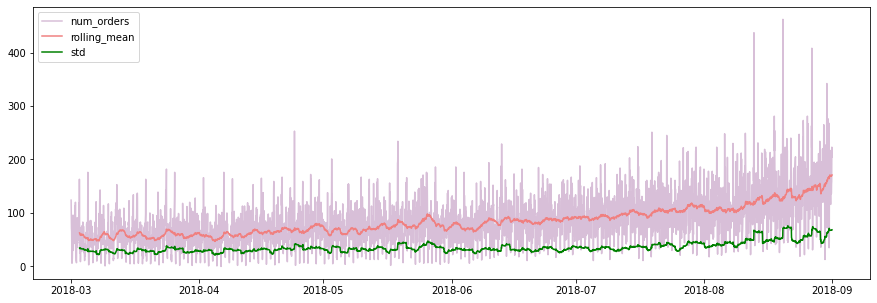

In [7]:
plt.plot(df['num_orders'], label='num_orders', color='thistle')
plt.plot(df['num_orders'].rolling(50).mean(), label='rolling_mean', color='lightcoral')
plt.plot(df['num_orders'].rolling(50).std(), label='std', color='green')
plt.legend()
plt.show()

In [8]:
# Напишем функцию для построения графика
def plotting(data, title):
    pastel_palette = sns.color_palette()
    pink_color = pastel_palette[6] 

    sns.lineplot(data=data, color=pink_color).set_title(title)
    plt.show()

In [9]:
# Декомпозируем данные
ddf = seasonal_decompose(df)

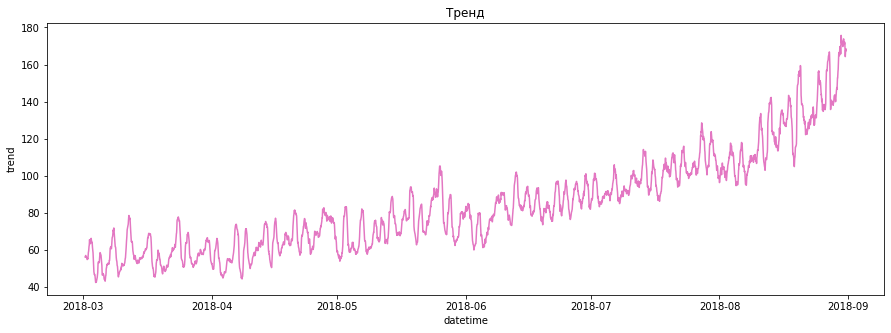

In [10]:
# График трендов
plotting(ddf.trend, 'Тренд')

По тренду видим, что к августу количество заказов повышается

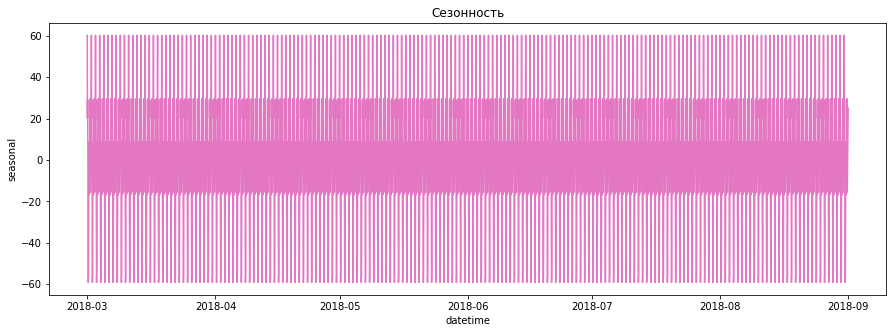

In [11]:
# График сезонности
plotting(ddf.seasonal, 'Сезонность')

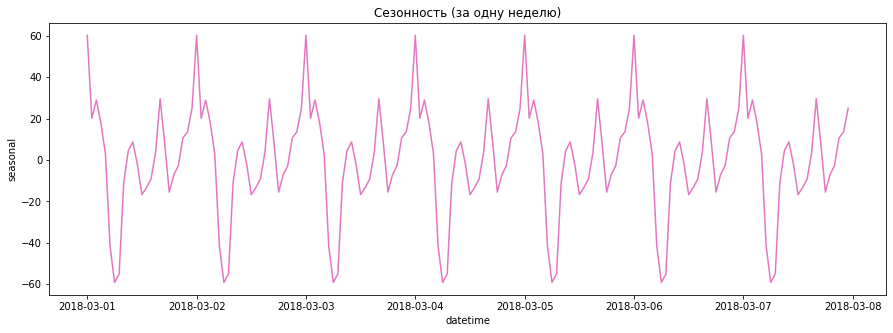

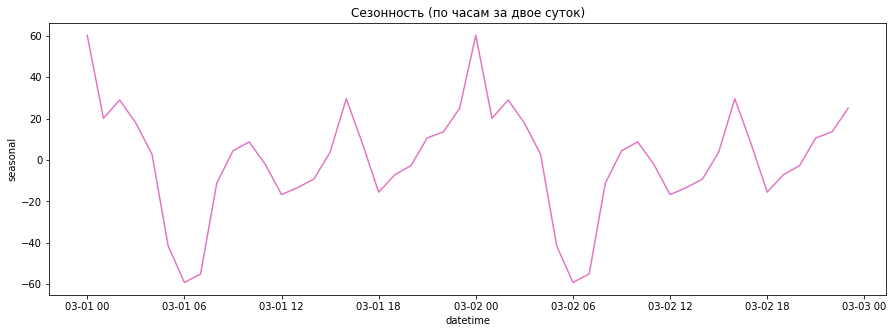

In [12]:
# Масштабируем график сезонности
plotting(ddf.seasonal['2018-03-01':'2018-03-07'], 'Сезонность (за одну неделю)')
plotting(ddf.seasonal['2018-03-01':'2018-03-02'], 'Сезонность (по часам за двое суток)')

Меньше всего заказов в 6:00, больше всего в 00:00

## Обучение

In [13]:
# Создадим функцию, которая добавляет признаки для обучения модели 
def features(df, max_lag, rolling_mean_size):
    data_copy = df.copy(deep=True)
    data_copy['dayofweek'] = data_copy.index.dayofweek
    data_copy['hour'] = data_copy.index.hour

    for lag in range(1, max_lag + 1):
        data_copy['lag_{}'.format(lag)] = data_copy['num_orders'].shift(lag)

    data_copy['rolling_mean'] = data_copy['num_orders'].shift().rolling(rolling_mean_size).mean()
    data_copy.dropna(inplace=True)

    return data_copy

In [14]:
# Создадим датасет для обучения моделей
dfm = features(df, 180, 180)

In [15]:
# Подготовим обучающую и тестовую выборки
RANDOM_STATE = 42
TEST_SIZE = 0.1

X = dfm.drop('num_orders', axis=1)
y = dfm['num_orders']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    shuffle=False,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE)

In [16]:
models = []

### LinearRegression

In [17]:
%%time

linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
cv = TimeSeriesSplit(n_splits=5)

linear_scores = cross_val_score(
    linear_model,
    X_train,
    y_train,
    cv=cv,
    n_jobs=-1,
    scoring='neg_root_mean_squared_error'
)

linear_rmse = (-1) * (sum(linear_scores) / len(linear_scores))
print(f'RMSE LinearRegression на кросс-валидации: {linear_rmse}')

linear_prediction = linear_model.predict(X_train)
linear_rmse_tr = np.sqrt(mean_squared_error(y_train, linear_prediction))
print(f'RMSE LinearRegression на тренировочной выборке: {linear_rmse_tr}')

models.append([linear_model, linear_rmse, linear_rmse_tr])

RMSE LinearRegression на кросс-валидации: 22.9274857257066
RMSE LinearRegression на тренировочной выборке: 20.36308585098863
CPU times: user 1.32 s, sys: 1.19 s, total: 2.51 s
Wall time: 2.46 s


### RandomForestRegressor

In [18]:
%%time

forest_model = RandomForestRegressor(random_state=RANDOM_STATE)

forest_params = {
    'n_estimators': range(50, 100, 10),
    'max_depth': range(5, 20, 5),
}

forest_grid = RandomizedSearchCV(
    forest_model,
    forest_params,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    n_iter=10,
    cv=cv,
    verbose=5,
    random_state=RANDOM_STATE
)

forest_grid.fit(X_train, y_train)
forest = forest_grid.best_estimator_
rmse_forest = (-1) * forest_grid.best_score_
print(f'Лучшая модель: \n {forest}')
print(f'RMSE RandomForestRegressor на кросс-валидации {rmse_forest}')

forest_prediction = forest.predict(X_train)
rmse_forest_tr = np.sqrt(mean_squared_error(y_train, forest_prediction))
print(f'RMSE RandomForestRegressor на тренировочной выборке: {rmse_forest_tr}')

models.append([forest, rmse_forest, rmse_forest_tr])

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END ..................max_depth=10, n_estimators=90; total time=   3.4s
[CV 2/5] END ..................max_depth=10, n_estimators=90; total time=   6.8s
[CV 3/5] END ..................max_depth=10, n_estimators=90; total time=  10.5s
[CV 4/5] END ..................max_depth=10, n_estimators=90; total time=  14.1s
[CV 5/5] END ..................max_depth=10, n_estimators=90; total time=  18.0s
[CV 1/5] END ..................max_depth=15, n_estimators=60; total time=   2.5s
[CV 2/5] END ..................max_depth=15, n_estimators=60; total time=   5.4s
[CV 3/5] END ..................max_depth=15, n_estimators=60; total time=   8.3s
[CV 4/5] END ..................max_depth=15, n_estimators=60; total time=  11.9s
[CV 5/5] END ..................max_depth=15, n_estimators=60; total time=  15.7s
[CV 1/5] END ...................max_depth=5, n_estimators=50; total time=   1.1s
[CV 2/5] END ...................max_depth=5, n_e

### CatBoostRegressor

In [19]:
%%time

catboost_model = CatBoostRegressor(random_state=RANDOM_STATE, verbose=False)

catboost_params = {
    'iterations': [100, 150, 200],  # Может быть увеличено, но лучше следить за переобучением.
    'l2_leaf_reg': [1, 3, 5, 7, 9]  # Наложение L2 регуляризации.
}

catboost_grid = RandomizedSearchCV(
    catboost_model,
    catboost_params,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    n_iter=10,  # Оптимальное количество итераций для Randomized Search.
    cv=cv,
    verbose=1,
    random_state=RANDOM_STATE
)

catboost_grid.fit(X_train, y_train)
catboost = catboost_grid.best_estimator_
score_catboost = cross_val_score(catboost, X_train, y_train, cv=cv, scoring='neg_root_mean_squared_error').mean()
catboost_rmse = (-1) * score_catboost
print(f"*Лучшая модель*: \n{catboost}")
print(f"RMSE на кросс-валидации: {catboost_rmse}")

catboost_prediction = catboost.predict(X_train)
catboost_rmse_tr = np.sqrt(mean_squared_error(y_train, catboost_prediction))
print(f"RMSE на тренировочной выборке: {catboost_rmse_tr}")

models.append((catboost, catboost_rmse, catboost_rmse_tr))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
*Лучшая модель*: 
RMSE на кросс-валидации: 22.90911454656723
RMSE на тренировочной выборке: 19.199930790429235
CPU times: user 4min 50s, sys: 2.6 s, total: 4min 53s
Wall time: 5min 37s


Проанализируем наши модели

In [20]:
model_rmse = pd.DataFrame(models, columns=['model', 'RMSE_cv', 'RMSE_train'])
model_rmse.sort_values('RMSE_cv')

,model,RMSE_cv,RMSE_train
2,<catboost.core.CatBoostRegressor object at 0x7...,22.909115,19.199931
0,LinearRegression(),22.927486,20.363086
1,"(DecisionTreeRegressor(max_depth=15, max_featu...",23.050485,8.609023


### Вывод:
- Лучшей моделью по метрике RMSE на кросс-валидации оказалась модель **LinearRegression** с показателем - **22.825**, на тренировочной выборке показатель RMSE - **20.335**
- Модель **CatBoostRegressor** показала RMSE на кросс-валидации **22.919**, на тренировочной выборке - **19.107**
- Лучшей моделью по метрике RMSE на тренировочной выборке оказалась модель **DecisionTreeRegressor** с показателем - **8.627**, но скорее всего модель переобучена, так как при кросс-валидации RMSE - **23.042**, слишком большая разница.

**LinearRegression**: Оптимальный выбор с учетом небольшого риска переобучения и хорошего баланса между RMSEcv и RMSEtrain.
**CatBoostRegressor**: Неплохой выбор, но более чувствителен к переобучению по сравнению с LinearRegression.\
**DecisionTreeRegressor**: Нельзя рекомендовать из-за значительного переобучения.

Выбираем **LinearRegression**

## Тестирование

In [21]:
y_pred = linear_model.predict(X_test)
best_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE лучшей модели на тестовой выборке: {best_rmse}')

RMSE лучшей модели на тестовой выборке: 34.35938599740812


In [22]:
# Визуализируем предсказания и истинные значения
def display_result(target, pred, rmse):
    result = target.to_frame().reset_index()
    result['prediction'] = pd.Series(pred)
    result.set_index('datetime', inplace=True)

    plotting(result, 'RMSE=' + str(rmse))

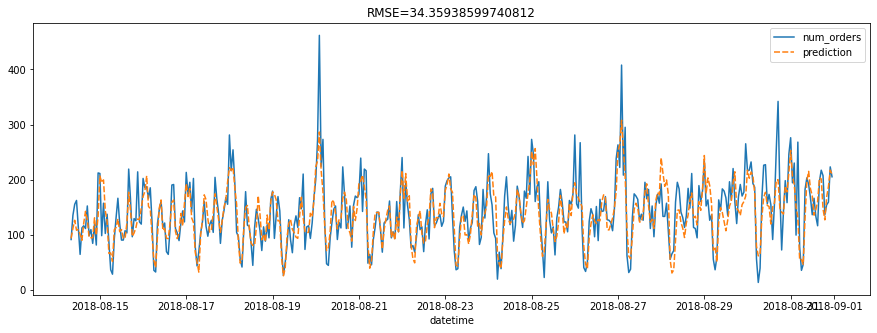

In [23]:
display_result(y_test, y_pred, best_rmse)

## Общий вывод:
1. В ходе работы мы подготовили данные:
    - Загрузили необходимые для работы библиотеки
    - Загрузили датасет
    - Проверили данные на наличие пропусков
    - Проверили типы данных
    - Ресеплировали данные по одному часу
    

2. Провели анализ данных:
    - Визуализировали данные
    - В 6:00 минимальное количество заказов
    - В 00:00 максимальное количество заказов
    

3. Обучили модели:
    - Разбили данные на тренировочную и тестовую выборки, тестовая выборка составила 10% от общего объема данных
    - **LinearRegression** при кросс-валидации показал результат RMSE 22.825, на тренировочной выборке - 20.335
    - **RandomForestRegressor** при кросс-валидации показал результат RMSE 8.627, на тренировочной выборке - 23.042
    - **CatBoostRegressor** при кросс-валидации показал результат RMSE 22.919, на тренировочной выборке - 19.107
    

4. Протестировали лучшую модель:
    - Лучшей моделью оказалась **LinearRegression**
    - RMSE на тестовой выборке - 35.425